# GUC Clustering Project 

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

The projects aims to teach student: 
* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

Students in this project will use ready-made functions from Sklearn, plotnine, numpy and pandas 
 



Running this project require the following imports 

In [3]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

## Multi Blob Data Set 
* The Data Set generated below has 6 cluster with varying number of users and varing densities
* Cluster the data set below using 



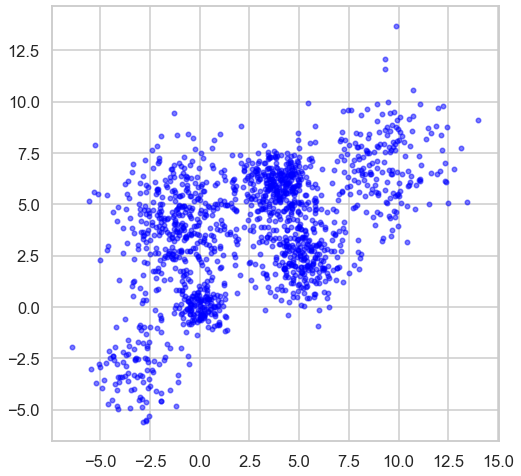

In [6]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### Kmeans 
* Use Kmeans with different values of K to cluster the above data 
* Display the outcome of each value of K 
* Plot distortion function versus K and choose the approriate value of k 
* Plot the silhouette_score versus K and use it to choose the best K 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 

{0, 1, 2, 3, 4, 5}
[[-2.06040723e+00 -1.32416008e+00  4.79115142e-01 -7.44287861e-01
  -6.58131621e-01  8.79394086e-01 -4.85519709e-01 -1.10903519e+00
  -4.53692734e-01 -1.41506628e+00  1.55801187e-02 -1.50585796e+00
  -1.25509450e+00 -1.29422210e+00 -2.16985559e+00  6.69001328e-01
  -5.24898972e+00  1.10823808e-02  2.90178603e-01 -8.22858123e-01
  -2.28173980e+00 -3.87802658e+00 -2.68060488e+00 -6.94179943e-01
  -2.68236783e+00 -2.67022857e+00 -2.02232499e+00 -3.70808935e+00
  -1.03338426e+00 -6.19345972e-01 -7.87118345e-01 -7.92094245e-01
  -9.16937880e-01 -2.19338587e+00 -3.38442896e+00 -3.11456750e+00
  -2.22129235e+00 -1.50141445e+00 -2.14493406e+00 -2.42008999e+00
  -3.01891731e+00  7.74206976e-02 -1.31498902e+00 -9.25520498e-01
   6.38594499e-01 -1.15007948e+00 -2.36624677e+00 -3.27287654e-02
  -1.64451716e+00 -9.42058104e-01 -4.37503605e-01 -4.38935059e+00
  -2.19852015e+00 -5.08442487e-02 -2.25040090e+00  8.55227205e-01
  -2.85693170e+00  1.06226609e+00 -6.73516502e-01 -7.7298

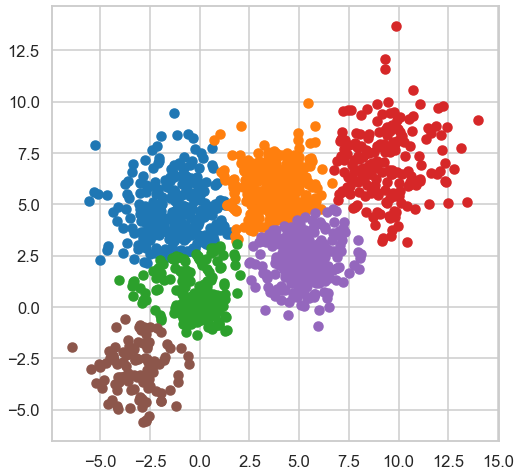

In [47]:
def kmeans(data,silhouette_plot=False,elbow_plot=False,plot=False):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    ks = [2, 3, 4, 5, 6]
    results = {}
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        ys = kmeans.fit_predict(data)
        results[k] = {'model': kmeans, "Y" : ys,'silhouette': silhouette_score(data, kmeans.labels_)}
    if silhouette_plot:
        si = [i["silhouette"] for i in results.values()]
        plt.plot(results.keys(),si)
        plt.show()
    if elbow_plot:
        from yellowbrick.cluster import KElbowVisualizer
        visualizer = KElbowVisualizer(KMeans, k=(1, 10), timings=False)
        visualizer.fit(data)
        visualizer.show()
    if plot:
        import operator
        tmp  = [r for r in results.values() if r["silhouette"] is not None]
        tmp.sort(key=operator.itemgetter('silhouette'))
        ys = tmp[-1]["Y"]
        set_cluster = set(ys)
        for c in set_cluster:
            plot_points = np.array([list(data[idx]) for idx,val in enumerate(ys) if val == c])
            plot_points = np.transpose(plot_points)
            plt.scatter(plot_points[0],plot_points[1])
        plt.show()

    return results

r = kmeans(Multi_blob_Data,plot=True)


### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data 
* In the  AgglomerativeClustering change the following parameters 
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage( use average and single )
    * Distance_threshold (try different)
* For each of these trials plot the Dendograph , calculate the silhouette_score and display the resulting clusters  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation 

In [102]:
def plot_dendrogram(model, **kwargs):
    from scipy.cluster.hierarchy import dendrogram
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

def hierarchal(data,silhouette_plot=False,dendro=False):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score


    affinities = ['euclidean', 'manhattan', 'cosine']
    linkages = ['average', 'single']
    distance_thresholds = [None, 2, 4, 6]

    results = {}
    for affinity in affinities:
        for linkage in linkages:
            for distance_threshold in distance_thresholds:
                if distance_threshold is None:
                    model = AgglomerativeClustering(n_clusters=3, affinity=affinity, linkage=linkage)
                else:
                    model = AgglomerativeClustering(n_clusters=None,affinity=affinity, linkage=linkage,
                                                    distance_threshold=distance_threshold)
                model.fit(Multi_blob_Data)
                if len(set(model.labels_)) == 1:
                    results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                    'silhouette': None}
                else:
                    results[(affinity, linkage, distance_threshold)] = {'model': model,
                                                                    'silhouette': silhouette_score(Multi_blob_Data, model.labels_)}
    if dendro:
        import operator
        tmp  = [r for r in results.values() if r["silhouette"] is not None]
        tmp.sort(key=operator.itemgetter('silhouette'))
        model = tmp[-1]["model"]
        plot_dendrogram(model)
    if silhouette_plot:
        si = [i["silhouette"] for i in results.values()]
        plt.plot(results.keys(),si)
        plt.show()

    return (results)

### DBScan
* Use DBScan function to  to cluster the above data 
* In the  DBscan change the following parameters 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
* Plot the silhouette_score versus the variation in the EPS and the min_samples
* Plot the resulting Clusters in this case 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments 

In [63]:
def dbscan(data):
    from sklearn.cluster import DBSCAN

    EPS = np.arange(0.1, 3.1, 0.2)
    Min_samples = np.arange(5,25,5)

    results={}
    for e in EPS:
        for s in Min_samples:
            dbscan = DBSCAN(eps=e, min_samples=s)
            dbscan.fit(data)
            if len(set(dbscan.labels_)) == 1:
                results[(e,s)]={"model":dbscan,"silhouette_score":None}
            else:
                results[(e,s)]={"model":dbscan,"silhouette_score":silhouette_score(data,dbscan.labels_)}
    return results

### Gaussian Mixture
* Use GaussianMixture function to cluster the above data 
* In GMM change the covariance_type and check the difference in the resulting proabability fit 
* Use a 2D contour plot to plot the resulting distribution (the components of the GMM) as well as the total Gaussian mixture 

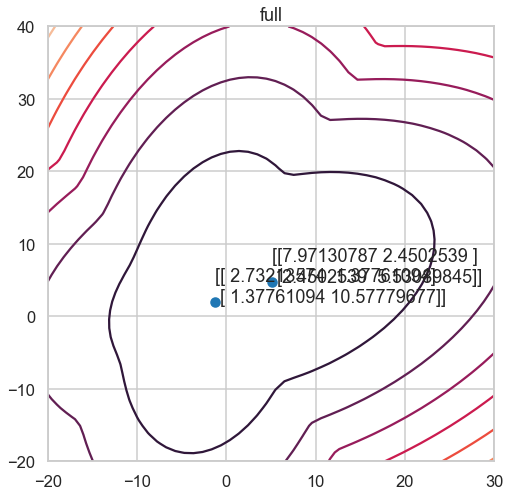

In [26]:
from sklearn import mixture

covariance_type = ["full"]
results = {}
for cov in covariance_type:
    gmm =  mixture.GaussianMixture(n_components = 2,covariance_type=cov)
    gmm.fit(Multi_blob_Data)
    results[cov] = {"model":gmm}
    x = np.linspace(-20.0, 30.0)
    y = np.linspace(-20.0, 40.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = - gmm.score_samples(XX)
    Z = Z.reshape(X.shape)
    contours = plt.contour(X, Y, Z)
    cn = np.transpose(gmm.means_)
    centers = plt.scatter(cn[0],cn[1])
    for i in range(len(cn)):
        plt.text(cn[0][i], cn[1][i], gmm.covariances_[i])
    plt.title(cov)
    plt.show()



## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers 

The data represents three classes 


In [72]:
from sklearn.datasets import load_iris
iris_data = load_iris()["data"]

* Repeat all the above clustering approaches and steps on the above data 
* Normalize the data then repeat all the above steps 
* Compare between the different clustering approaches 

### kmeans

In [75]:
kmeans(iris_data)

{2: {'model': KMeans(n_clusters=2), 'silhouette': 0.6810461692117462},
 3: {'model': KMeans(n_clusters=3), 'silhouette': 0.5528190123564094},
 4: {'model': KMeans(n_clusters=4), 'silhouette': 0.4980505049972871},
 5: {'model': KMeans(n_clusters=5), 'silhouette': 0.4887488870931052},
 6: {'model': KMeans(n_clusters=6), 'silhouette': 0.36483400396700233}}

### DbScan

{('euclidean',
  'average',
  None): {'model': AgglomerativeClustering(linkage='average', n_clusters=3), 'silhouette': 0.4307906732655957},
 ('euclidean',
  'average',
  2): {'model': AgglomerativeClustering(distance_threshold=2, linkage='average',
                          n_clusters=None), 'silhouette': 0.31557101720950825},
 ('euclidean',
  'average',
  4): {'model': AgglomerativeClustering(distance_threshold=4, linkage='average',
                          n_clusters=None), 'silhouette': 0.37378418096239385},
 ('euclidean',
  'average',
  6): {'model': AgglomerativeClustering(distance_threshold=6, linkage='average',
                          n_clusters=None), 'silhouette': 0.4307906732655957},
 ('euclidean',
  'single',
  None): {'model': AgglomerativeClustering(linkage='single', n_clusters=3), 'silhouette': 0.23622772250901033},
 ('euclidean',
  'single',
  2): {'model': AgglomerativeClustering(distance_threshold=2, linkage='single', n_clusters=None), 'silhouette': 0.32180662048471

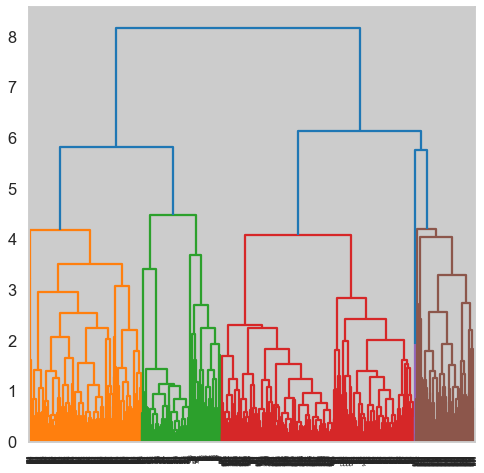

In [103]:
hierarchal(iris_data,True)

## Customer dataset
Repeat all the above on the customer data set 